All Results:
                Meta Model                                        Base Models  \
0        gradient_boosting   [xgboost, random_forest, chi_square_pruned_tree]   
1        gradient_boosting   [xgboost, chi_square_pruned_tree, random_forest]   
2        gradient_boosting   [random_forest, xgboost, chi_square_pruned_tree]   
3        gradient_boosting   [random_forest, chi_square_pruned_tree, xgboost]   
4        gradient_boosting   [chi_square_pruned_tree, xgboost, random_forest]   
5        gradient_boosting   [chi_square_pruned_tree, random_forest, xgboost]   
6                  xgboost  [gradient_boosting, random_forest, chi_square_...   
7                  xgboost  [gradient_boosting, chi_square_pruned_tree, ra...   
8                  xgboost  [random_forest, gradient_boosting, chi_square_...   
9                  xgboost  [random_forest, chi_square_pruned_tree, gradie...   
10                 xgboost  [chi_square_pruned_tree, gradient_boosting, ra...   
11             

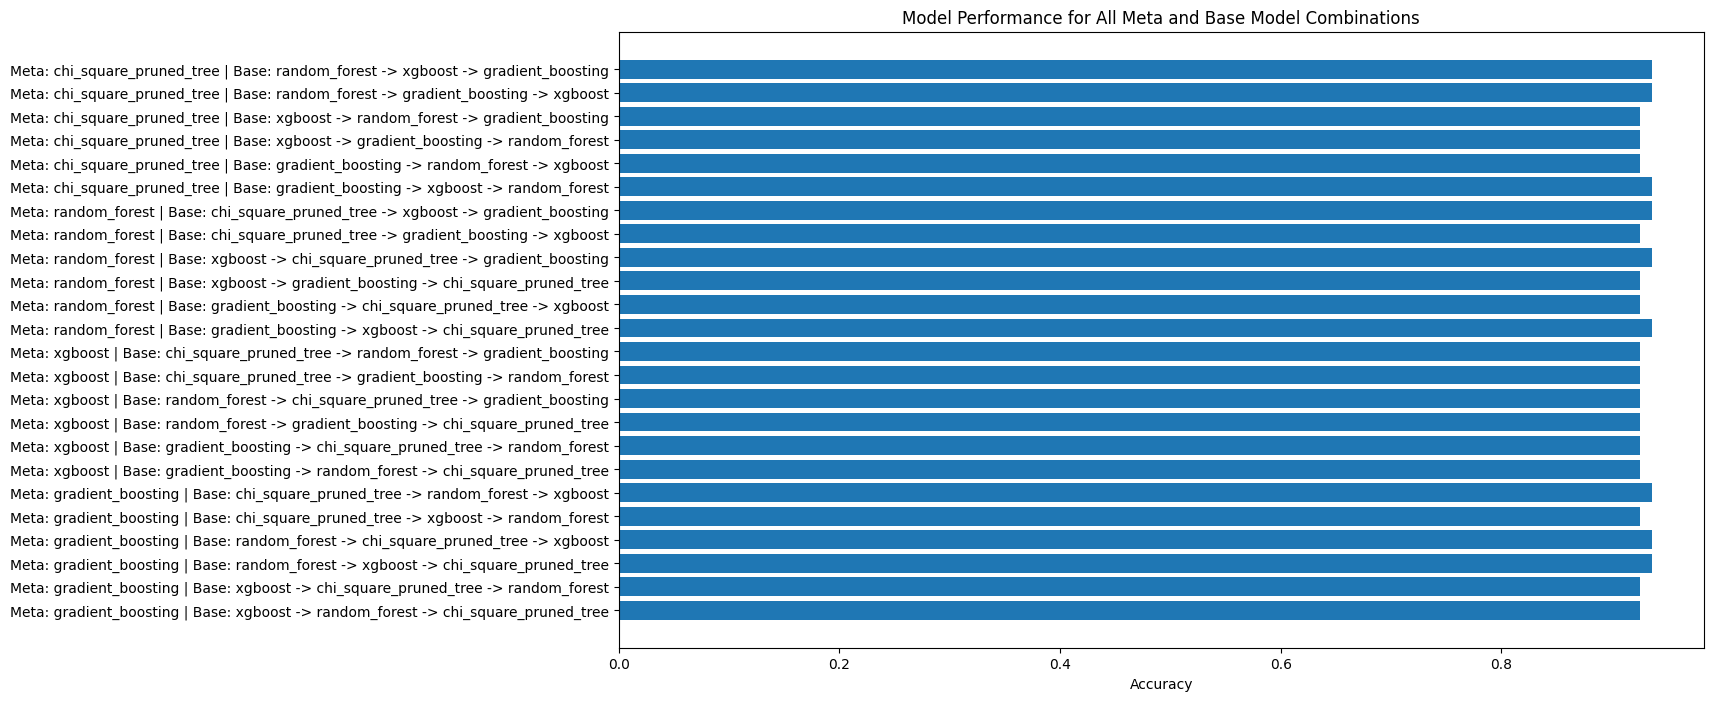

In [1]:
import itertools
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Chi-Square Pruned Tree class
class ChiSquarePrunedTree:
    def __init__(self, max_depth=None, min_samples_split=2, alpha=0.05):
        self.tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        self.alpha = alpha

    def fit(self, X, y):
        self.tree.fit(X, y)
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y

    def prune(self):
        tree = self.tree.tree_
        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        threshold = tree.threshold

        def prune_node(node):
            if children_left[node] == -1 and children_right[node] == -1:
                return

            left = children_left[node]
            right = children_right[node]

            if left == -1 or right == -1:
                return

            left_samples = self.y[self.X[:, feature[node]] <= threshold[node]]
            right_samples = self.y[self.X[:, feature[node]] > threshold[node]]

            contingency_table = np.array([
                [np.sum(left_samples == c), np.sum(right_samples == c)] for c in np.unique(self.y)
            ])

            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            if p_value > self.alpha:
                children_left[node] = -1
                children_right[node] = -1

            prune_node(left)
            prune_node(right)

        prune_node(0)

    def predict(self, X):
        if isinstance(X, pd.DataFrame):
            return self.tree.predict(X)
        else:
            raise ValueError("Input data X must be a pandas DataFrame with feature names.")

# Load dataset
df = pd.read_csv('df_one_hot_encoded_normalized.csv')  # Replace with your actual path
train_data = df[(df['Target'] == '0') | (df['Target'] == '1')]  # Training data (rows labeled 0 and 1)
X = train_data.drop(columns=['Target'])
y = train_data['Target'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
gradient_boosting = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, random_state=42)
xgboost = XGBClassifier(learning_rate=0.1, max_depth=9, eval_metric='mlogloss', random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
chi_square_pruned_tree = ChiSquarePrunedTree(max_depth=5, min_samples_split=5, alpha=0.1)

# Test all combinations of meta-model and base-models
all_models = [
    ('gradient_boosting', gradient_boosting),
    ('xgboost', xgboost),
    ('random_forest', random_forest),
    ('chi_square_pruned_tree', chi_square_pruned_tree),
]

results = []

# Loop through all possible combinations
for meta_model_name, meta_model in all_models:
    base_models = [model for model in all_models if model[0] != meta_model_name]
    base_combinations = list(itertools.permutations(base_models, len(base_models)))

    for base_combination in base_combinations:
        # Train base models and collect predictions
        base_train_preds = []
        for name, model in base_combination:
            model.fit(X_train, y_train)  # Ensure training uses DataFrame format
            base_train_preds.append(model.predict(X_train))

        stacked_features = pd.DataFrame(np.column_stack(base_train_preds), columns=[name for name, _ in base_combination])
        meta_model.fit(stacked_features, y_train)

        # Test base models and collect predictions
        base_test_preds = [model.predict(X_test) for _, model in base_combination]
        stacked_test_features = pd.DataFrame(np.column_stack(base_test_preds), columns=[name for name, _ in base_combination])
        y_pred = meta_model.predict(stacked_test_features)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'Meta Model': meta_model_name,
            'Base Models': [name for name, _ in base_combination],
            'Accuracy': accuracy
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Accuracy'].idxmax()]

# Display results
print("All Results:")
print(results_df)
print("\nBest Result:")
print(best_result)

# Visualize results
plt.figure(figsize=(14, 8))
plt.barh(
    results_df.index,
    results_df['Accuracy'],
    tick_label=[
        f"Meta: {row['Meta Model']} | Base: " + " -> ".join(row['Base Models']) for _, row in results_df.iterrows()
    ]
)
plt.xlabel("Accuracy")
plt.title("Model Performance for All Meta and Base Model Combinations")
plt.show()


In [3]:
import itertools
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from joblib import Parallel, delayed
from itertools import permutations

# Chi-Square Pruned Tree class
class ChiSquarePrunedTree:
    def __init__(self, max_depth=None, min_samples_split=2, alpha=0.05):
        self.tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        self.alpha = alpha

    def fit(self, X, y):
        self.tree.fit(X, y)
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y

    def prune(self):
        tree = self.tree.tree_
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        threshold = tree.threshold

        def prune_node(node):
            if children_left[node] == -1 and children_right[node] == -1:
                return

            left = children_left[node]
            right = children_right[node]

            if left == -1 or right == -1:
                return

            left_samples = self.y[self.X[:, feature[node]] <= threshold[node]]
            right_samples = self.y[self.X[:, feature[node]] > threshold[node]]

            contingency_table = np.array([
                [np.sum(left_samples == c), np.sum(right_samples == c)] for c in np.unique(self.y)
            ])

            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            if p_value > self.alpha:
                children_left[node] = -1
                children_right[node] = -1

            prune_node(left)
            prune_node(right)

        prune_node(0)

    def predict(self, X):
        return self.tree.predict(X)

# Load dataset
df = pd.read_csv('df_one_hot_encoded_normalized.csv')  # Replace with your actual path
train_data = df[(df['Target'] == '0') | (df['Target'] == '1')]  # Binary classification data
X = train_data.drop(columns=['Target'])
y = train_data['Target'].astype(int)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models_with_params = [
    ("chi_square_pruned_tree", ChiSquarePrunedTree(max_depth=5, min_samples_split=5, alpha=0.01)),
    ("gradient_boosting", GradientBoostingClassifier(learning_rate=0.1, max_depth=7, random_state=42)),
    ("xgboost", XGBClassifier(learning_rate=0.1, max_depth=9, eval_metric='mlogloss', random_state=42)),
    ("bernoulli_nb", BernoulliNB(alpha=2.0, binarize=0.0)),
    ("random_forest", RandomForestClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, n_estimators=100, random_state=42)),
    ("svm", SVC(C=100, gamma=1, kernel="linear", probability=True, random_state=42)),
    ("mlp", MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)),
    ("logistic_regression", LogisticRegression(max_iter=1000, random_state=42)),
]

# Precompute base model predictions
def compute_base_predictions(models, X_train, y_train, X_test):
    train_preds = {}
    test_preds = {}
    for name, model in models:
        model.fit(X_train, y_train)
        train_preds[name] = model.predict(X_train)
        test_preds[name] = model.predict(X_test)
    return train_preds, test_preds

# Evaluate meta-models with 4 base models and order importance
def evaluate_meta_model_with_order(meta_model_name, meta_model, base_models, train_preds, test_preds, y_train, y_test):
    results = []
    for base_permutation in permutations(base_models, 4):  # Select and order 4 base models
        base_names = [name for name, _ in base_permutation]
        stacked_features_train = np.column_stack([train_preds[name] for name in base_names])
        stacked_features_test = np.column_stack([test_preds[name] for name in base_names])

        meta_model.fit(stacked_features_train, y_train)
        y_pred = meta_model.predict(stacked_features_test)
        accuracy = accuracy_score(y_test, y_pred)

        results.append({
            'Meta Model': meta_model_name,
            'Base Models (Ordered)': base_names,
            'Accuracy': accuracy
        })
    return results

# Compute base predictions
train_preds, test_preds = compute_base_predictions(models_with_params, X_train, y_train, X_test)

# Parallel evaluation with order importance
all_results_with_order = Parallel(n_jobs=-1)(
    delayed(evaluate_meta_model_with_order)(
        meta_model_name, meta_model,
        [m for m in models_with_params if m[0] != meta_model_name],  # Exclude current meta-model from base models
        train_preds, test_preds, y_train, y_test
    )
    for meta_model_name, meta_model in models_with_params
)

# Combine results
results_with_order_df = pd.DataFrame([item for sublist in all_results_with_order for item in sublist])

# Display best result
best_result_with_order = results_with_order_df.loc[results_with_order_df['Accuracy'].idxmax()]
print("All Results with Order Considered:")
print(results_with_order_df)
print("\nBest Result with Order Considered:")
print(best_result_with_order)


All Results with Order Considered:
                  Meta Model  \
0     chi_square_pruned_tree   
1     chi_square_pruned_tree   
2     chi_square_pruned_tree   
3     chi_square_pruned_tree   
4     chi_square_pruned_tree   
...                      ...   
6715     logistic_regression   
6716     logistic_regression   
6717     logistic_regression   
6718     logistic_regression   
6719     logistic_regression   

                                  Base Models (Ordered)  Accuracy  
0     [gradient_boosting, xgboost, bernoulli_nb, ran...  0.925620  
1       [gradient_boosting, xgboost, bernoulli_nb, svm]  0.936639  
2       [gradient_boosting, xgboost, bernoulli_nb, mlp]  0.936639  
3     [gradient_boosting, xgboost, bernoulli_nb, log...  0.936639  
4     [gradient_boosting, xgboost, random_forest, be...  0.925620  
...                                                 ...       ...  
6715            [mlp, svm, bernoulli_nb, random_forest]  0.910468  
6716  [mlp, svm, random_forest, chi_

In [5]:
best_result_with_order["Base Models (Ordered)"]

['chi_square_pruned_tree', 'random_forest', 'xgboost', 'bernoulli_nb']